# `MIDAS`

$ \textrm{We want to maximize the media-driven NOS of a media plan, by deciding the amount of budget per vehicle that we should spend} $
$ \textrm{for a given brand/market combination on a given period. Specifically,}$<br>
<br>
$ \textrm{Given } \textit{N} \textrm{ response curves } \textit{i}:$<br><br>
&emsp;&emsp;$ \textrm{max} \sum \limits _{i=1} ^{N} f^{NOS}_{i}(\tilde{x}_{i})$<br>
&emsp;&emsp;&emsp;$ s.t. \; 1 \geq \tilde{x}_{i} \geq 0 \;\;\;\;\;\;\;\;\;\;\;\;  (1)$ <br>
&emsp;&emsp;&emsp;&emsp;&emsp;$    \; \sum _{i=1} ^{N} y_{i} \leq budget \;\;\; (2)$<br><br>

&emsp;&emsp;$ \textrm{where:} $<br> 
&emsp;&emsp;&emsp;&emsp;$ f^{NOS}_{i} = \textrm{ fitted } \textit{NOS}  \textrm{ function for the } \textit{i} \textrm{-th media vehicle}$<br>
&emsp;&emsp;&emsp;&emsp;$ \tilde{x}_{i} = \textrm{ }\mathbf{scaled} \textrm{ total impressions} \textrm{: } \tilde{x}_{i} =  \frac{x_{i} - x_{min}}{x_{max}-x_{min}} $<br>
&emsp;&emsp;&emsp;&emsp;$ x_{i} = \textrm{ total } \mathbf{impressions} \textrm{ given spend } y_{i} \textrm{: } x_{i} = g^{impressions}_{i}(y_{i}) $<br>
&emsp;&emsp;&emsp;&emsp;$ g^{impressions}_{i} = \textrm{ fitted } \textit{impressions}  \textrm{ function for the } \textit{i} \textrm{-th media vehicle}$<br>
&emsp;&emsp;&emsp;&emsp;$ y_{i} = \textrm{ total } \mathbf{spend} \textrm{ on the } \textit{i} \textrm{-th media vehicle}$<br>


In [4]:
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import math

In [5]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [6]:
from funcs.proi import *

ModuleNotFoundError: No module named 'funcs'

---
## Load data

In [ ]:
## config
config = pd.read_excel('../data/midas/midas-pe-pantene.xlsx')
market = config.market.unique()[0]
brand = config.brand.unique()[0]

In [ ]:
# data
curves = pd.read_csv('../data/database-curves.csv')
financials =  pd.read_excel('../data/database-financials.xlsx')

In [ ]:
# set entity
curves = curves.query(f'market == "{market}" & brand == "{brand}"')
vehicles = set([v for v in curves.vehicle.unique()])

data_dict = {v: {'data': curves.query(f'vehicle == "{v}"')[['Weekly Support','Prediction']]} for v in vehicles}

for k in data_dict.keys():
    data_dict[k]['cpp'] = financials[(financials.vehicle==k)&(financials.market==market)&(financials.brand==brand)&(financials.metric=='cpp')]['value'].values[0]
    
    try:
        data_dict[k]['spend'] = config[(config.vehicle==k)&(config.metric=='spend')]['value'].values[0]
        data_dict[k]['weeks'] = config[(config.vehicle==k)&(config.metric=='weeks')]['value'].values[0]
        data_dict[k]['ix_spend'] = config[(config.vehicle==k)&(config.metric=='ix_spend')]['value'].values[0]
        data_dict[k]['ix_nos'] = config[(config.vehicle==k)&(config.metric=='ix_nos')]['value'].values[0]
        data_dict[k]['imp'] = data_dict[k]['spend'] / data_dict[k]['cpp'] * data_dict[k]['ix_spend'] / data_dict[k]['weeks']
    except:
        print(f'Missing vehicle: {k}')
        data_dict[k]['spend'] = 0
        data_dict[k]['weeks'] = 52
        data_dict[k]['ix_spend'] = financials[(financials.vehicle==k)&(financials.market=='all')&(financials.metric=='ix_spend')]['value'].values[0]
        data_dict[k]['ix_nos'] = financials[(financials.vehicle==k)&(financials.market=='all')&(financials.metric=='ix_nos')]['value'].values[0]
        data_dict[k]['imp'] = 0

NOS_PER_SU = financials[(financials.vehicle=='total')&(financials.market==market)&(financials.brand==brand)&(financials.metric=='nos_per_su')]['value'].values[0]
TOTAL_SPEND = np.sum([data_dict[k]['spend'] for k in data_dict.keys()])

Missing vehicle: yt
Missing vehicle: social


---
## Fit curves

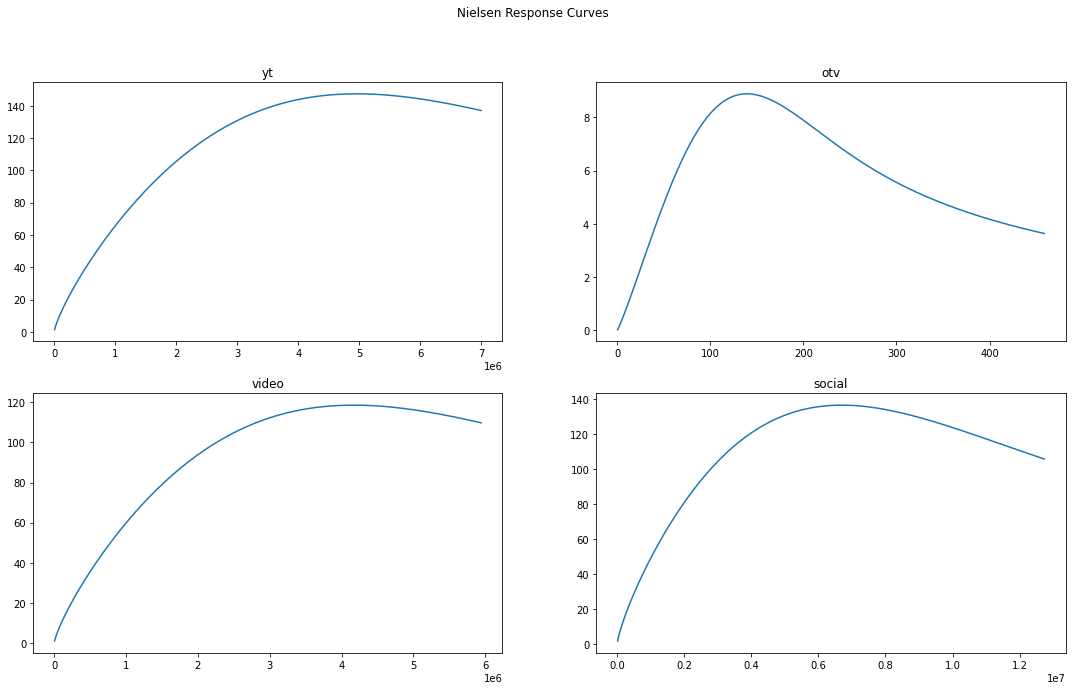

In [ ]:
# Plot curves
plot_curves(data_dict)

In [ ]:
funcs = [hill, poly2, log_, cdf_, weibull]
data_dict = fit_curves(funcs=funcs, data_dict=data_dict, poly1d=True)

yt
----------
r2: 1.0

otv
----------
r2: 0.995

video
----------
r2: 1.0

social
----------
r2: 1.0



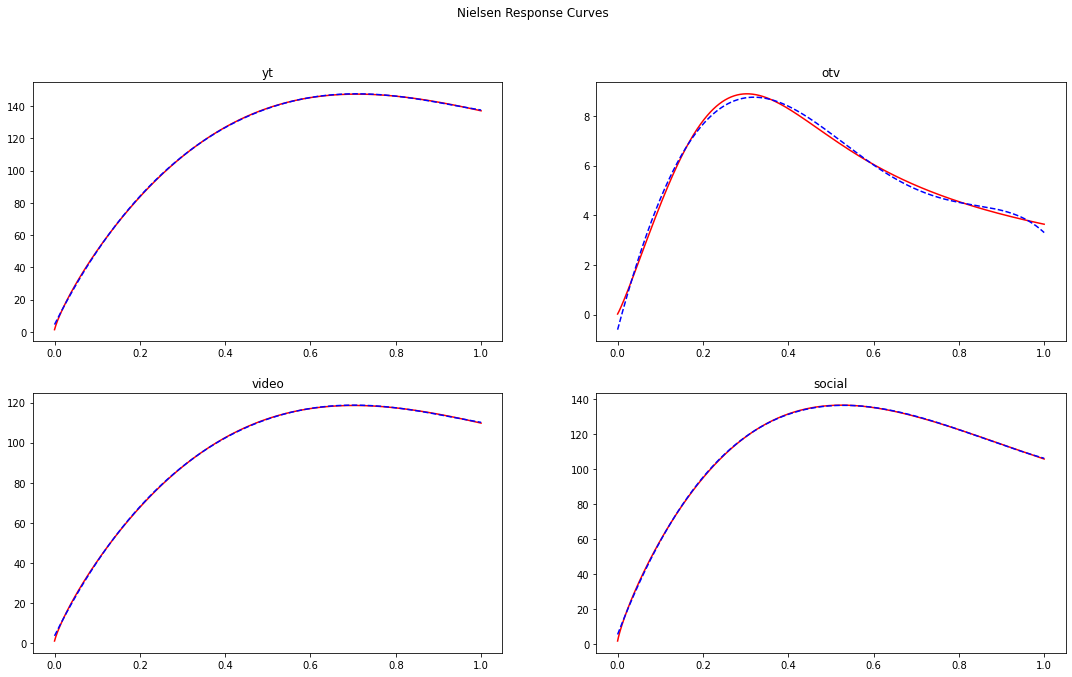

In [ ]:
plot_fitted_curves(data_dict)

---
## `MIDAS NOS·Translator`

In [ ]:
def objective(x:list) -> float:
    '''
    Total NOS per SU given impressions per vehicle
    
    Args:
        x: a list with impressions per vehicle

    Returns:
        Total NOS per SU achieved
    '''
    return -(NOS_PER_SU * \
             np.sum([get_nos(x[i], data_dict, k) for i, k in enumerate(data_dict.keys())])
            )

In [ ]:
actuals = np.array([data_dict[k]['scaler'].transform([[data_dict[k]['imp']]])[0][0] \
              for k in data_dict.keys()])
print(f'Current NOS: ${-objective(actuals):,.2f}')
print(f'Current ROI: {-objective(actuals)/TOTAL_SPEND:,.2f}')
print(f'Total SU: {-objective(actuals)/NOS_PER_SU:,.2f}')

print()
print('spent')
print('-'*20)
for i, k in enumerate(data_dict.keys()):
    print(f'{k}: ${round(get_spend(actuals[i], data_dict, k)):,.2f}')

Current NOS: $4,754,186.90
Current ROI: 0.64
Total SU: 87,890.82

spent
--------------------
yt: $0.00
otv: $5,189,686.00
video: $2,287,114.00
social: $0.00


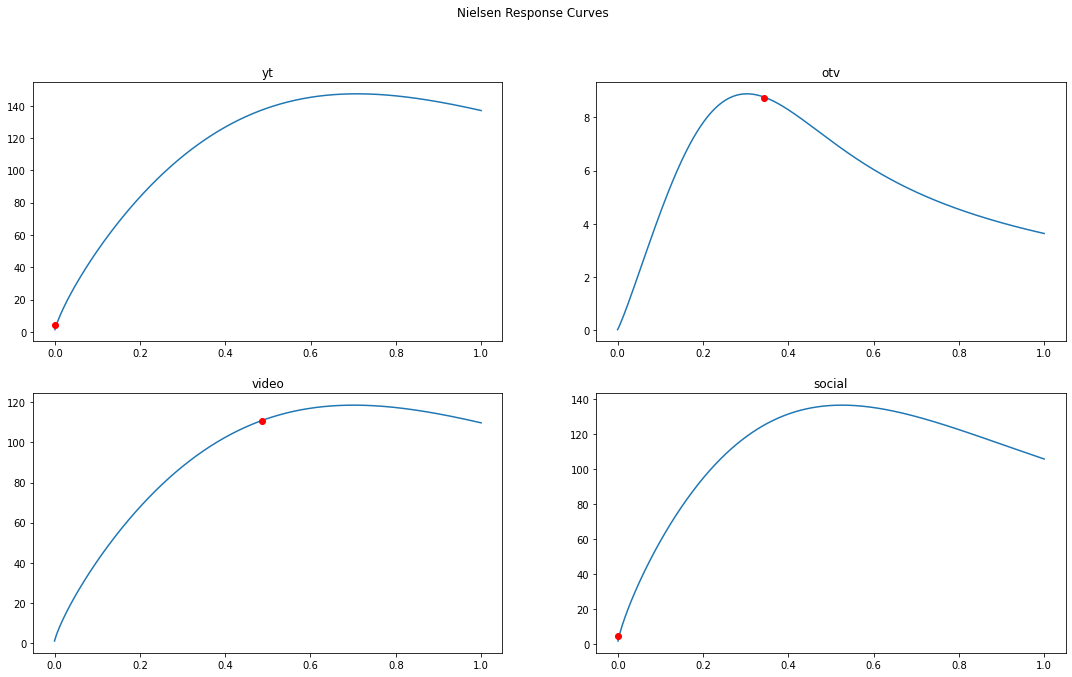

In [ ]:
plot_actual_curves(data_dict=data_dict, x=actuals)

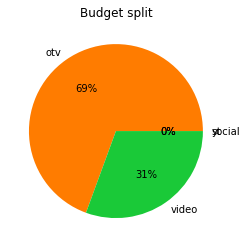

In [ ]:
keys = [k for k in data_dict.keys()]
values = [round(get_spend(actuals[i], data_dict, k)) for i, k in enumerate(data_dict.keys())]

plt.pie(values, labels=keys, colors=sns.color_palette('bright'), autopct='%.0f%%')
plt.title('Budget split')
plt.show()

---

## `MIDAS NOS·Optimizer`

In [ ]:
def constraint1(x:list) -> float:
    '''
    Total spend given impressions per vehicle
    
    Args:
        x: a list with impressions per vehicle

    Returns:
        Exceeding budget spent
    '''
    return TOTAL_SPEND - \
            np.sum([get_spend(x[i], data_dict, k) for i, k in enumerate(data_dict.keys())])

In [ ]:
initial_guess = [np.random.random() for _ in range(len(data_dict.keys()))]
cons = [{'type': 'ineq', 'fun': constraint1}]

result = minimize(objective, 
                  initial_guess, 
                  method = 'trust-constr',
                  constraints=cons,
                  bounds=[(0.01, 1.1) for _ in range(len(data_dict.keys()))],
                  options={'maxiter': 2_000, 'verbose':2},
                 )

print(result.message)
print()
print(result.x)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | -8.6230e+06 | 1.00e+00 | 8.25e+05 | 6.35e+06 |
|   2   |  10   |   1   | -6.4770e+06 | 2.00e+00 | 6.66e+05 | 0.00e+00 |
|   3   |  15   |   4   | -6.7188e+06 | 6.66e+00 | 3.65e+05 | 0.00e+00 |
|   4   |  20   |   7   | -6.9782e+06 | 6.66e+00 | 2.76e+05 | 0.00e+00 |
|   5   |  25   |  10   | -7.2504e+06 | 6.66e+00 | 2.89e+05 | 0.00e+00 |
|   6   |  30   |  13   | -8.9081e+06 | 1.43e+01 | 1.77e+04 | 0.00e+00 |
|   7   |  35   |  16   | -8.9459e+06 | 1.43e+01 | 2.28e+04 | 0.00e+00 |
|   8   |  40   |  18   | -8.9502e+06 | 1.43e+01 | 1.83e+04 | 0.00e+00 |
|   9   |  45   |  20   | -8.9520e+06 | 1.43e+01 | 2.54e+03 | 0.00e+00 |
|  10   |  50   |  22   | -8.9521e+06 | 1.43e+01 | 4.78e+01 | 0.00e+00 |
|  11   |  55   |  24   | -8.9521e+06 | 1.43e+01 | 1.45e-01 | 0.00e+00 |
|  12   |  60   |  28   | -8.9521e+06 | 2.29e+01 | 

In [ ]:
EPS = 1

# re-check constraints!
spend_const = (np.sum([get_spend(result.x[i], data_dict, k) for i, k in enumerate(data_dict.keys())]) <= TOTAL_SPEND + EPS)
bound_const = (all([(i >= 0) & (i <= 1) for i in [*result.x]]))
objective_const = (-objective(actuals) < -objective(result.x))

print('constraints')
print('-'*13)
print(f'Budget: \t{spend_const}')
print(f'Bounds: \t{bound_const}')
print(f'Objective: \t{objective_const}')

constraints
-------------
Budget: 	True
Bounds: 	False
Objective: 	True


In [ ]:
print(f'Result (NOS): ${-objective(result.x):,.2f} (+${round(-objective(result.x)+objective(actuals)):,.0f})')
print(f'Result (ROI): {-objective(result.x)/TOTAL_SPEND:,.2f} ({(-objective(result.x)/TOTAL_SPEND)-(-objective(actuals)/TOTAL_SPEND):,.2f})')
print()

print('NOS:')
print('-'*20)
for i, k in enumerate(data_dict.keys()):
    print(f'{k}: ${round(get_nos(result.x[i], data_dict, k) * NOS_PER_SU):,.2f}')

print()

print('spent')
print('-'*20)
for i, k in enumerate(data_dict.keys()):
    print(f'{k}: ${round(get_spend(result.x[i], data_dict, k)):,.2f}')

Result (NOS): $8,952,083.89 (+$4,197,897)
Result (ROI): 1.20 (0.56)

NOS:
--------------------
yt: $2,917,191.00
otv: $2,673,382.00
video: $1,442.00
social: $3,360,068.00

spent
--------------------
yt: $1,615,978.00
otv: $3,748,063.00
video: $51,748.00
social: $2,061,011.00


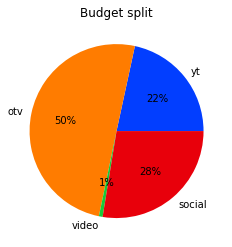

In [ ]:
keys = [k for k in data_dict.keys()]
values = [round(get_spend(result.x[i], data_dict, k)) for i, k in enumerate(data_dict.keys())]

plt.pie(values, labels=keys, colors=sns.color_palette('bright'), autopct='%.0f%%')
plt.title('Budget split')
plt.show()

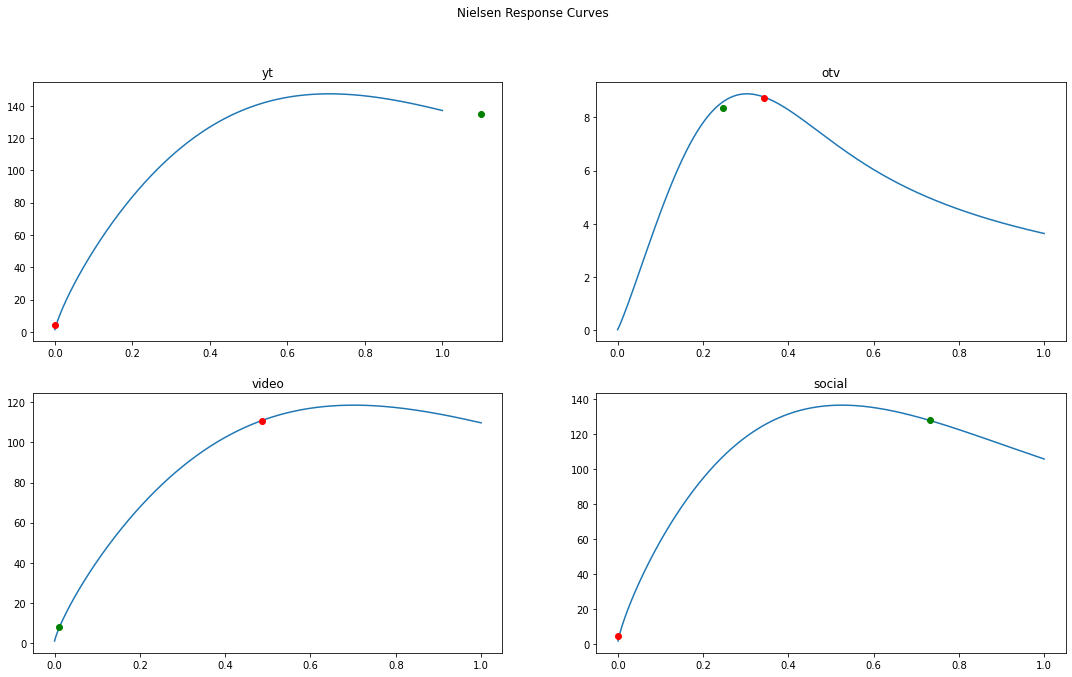

In [ ]:
plot_solution_curves(data_dict=data_dict, x=result.x, actual=actuals)

---